In [1]:
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import hist
from hist import Hist
import pickle
import mplhep as hep
import math
from tabulate import tabulate
import warnings
from plot_utils import *

warnings.filterwarnings('ignore')
hep.style.use("CMS")
matplotlib.rcParams.update({'figure.max_open_warning': 0})

#### Notebook Parameters
`tag`: _str_, tag used to identify which .pkl files to import. Will select `infile_names` to have `<tag>.pkl`.<br>
`output_label`: _str_, saves plots as `<output_label>+<plot_name>.<file_ext>`.<br>
`file_ext`: _str_, see above.<br>
`infile_names`: _array of str_: full paths of .pkl files.<br>

In [23]:
# parameters
input_label = 'raw'
output_label = '/home/submit/lavezzo/public_html/SUEP/raw/'
file_ext = '.png'

# input .pkl files
plotDir = os.getcwd()
infile_all = [plotDir+'/outputs/'+dataset for dataset in os.listdir(plotDir+'/outputs/')]

# some predefined samples to choose from
infile_names_2018 = [f for f in infile_all if '20UL18' in f or 'UL2018' in f]
infile_names_2018_data = [f for f in infile_all if 'UL2018' in f]
infile_names_2017 = [f for f in infile_all if '20UL17' in f or 'UL2017' in f]
infile_names_2016 = [f for f in infile_all if ('20UL16MiniAODv2' in f or 'UL2016' in f) \
                     and ('HIPM_UL' not in f)]
infile_names_2016_apv = [f for f in infile_all if ('20UL16MiniAODAPVv2' in f or 'HIPM_UL2016' in f)]
infile_names_SUEP = [f for f in infile_all if ('SUEP-m' in f)]


# assign your choice to infile_names
infile_names = infile_names_2018 + infile_names_SUEP
includers = [input_label+'.pkl']
excluders = ['QCD_Pt', '.root']
infile_names = [f for f in infile_names if all([i in f for i in includers])]
infile_names = [f for f in infile_names if not any([e in f for e in excluders])]

The `plots` dictionary is used to store all the plots imported from the pickle files. Dimensions: (real or MC) x (plot label) <br>
The `data` nested dictionary stores the number of events and variances in each region for real data and MC data when the plots are made, and is used to make the comparison table. Dimensions: (real or MC) x (plot label) x (value or error on the value)

In [24]:
# dimensions: (data or MC) x (plot label) x (value or error on the value)
stats = nested_dict(4,float)

# dimensions: (data or MC) x (plot label)
plots = {}

# create output dir
if not os.path.isdir(output_label): 
    print("Creating", output_label)
    os.mkdir(output_label)

# load file(s)
for infile_name in infile_names:
    if not os.path.isfile(infile_name): 
        print("WARNING:",infile_name,"doesn't exist")
        continue
    elif input_label not in infile_name: continue
    elif ".pkl" not in infile_name: continue
    elif "QCD_Pt_3200toInf_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-pilot" in infile_name: continue
    
    # sets the lumi based on year
    if ('20UL16MiniAODv2' in infile_name):
        lumi = lumis['2016']
    if ('20UL17MiniAODv2' in infile_name):
        lumi = lumis['2017']
    if ('20UL16MiniAODAPVv2' in infile_name):
        lumi = lumis['2016_apv']
    if ('20UL18' in infile_name):
        lumi = lumis['2018']
    if 'SUEP-m' in infile_name:
        lumi = lumis['2018']
    if 'JetHT+Run' in infile_name:
        lumi = 1
        
    # print("Loading",infile_name.split("/")[-1])
    # print(lumi)

    # plots[sample] sample is set here
    # for QCD, add each bin as well as combine
    if 'QCD_Pt' in infile_name or 'QCD_HT' in infile_name:
        temp_sample = infile_name.split('/')[-1].split('.pkl')[0]
        plots[temp_sample] = openpkl(infile_name)
        for plot in list(plots[temp_sample].keys()):
            plots[temp_sample][plot] = plots[temp_sample][plot]*lumi
        sample = 'QCD_MC'
    elif 'JetHT+Run' in infile_name: 
        temp_sample = infile_name.split('/')[-1].split('.pkl')[0]
        plots[temp_sample] = openpkl(infile_name)
        for plot in list(plots[temp_sample].keys()):
            plots[temp_sample][plot] = plots[temp_sample][plot]
        sample = 'data'
    elif 'SUEP-m' in infile_name:
        sample = infile_name.split('/')[-1].split('+')[0]
    else: 
        sample = infile_name.split('/')[-1].split('.pkl')[0]

    if sample not in list(plots.keys()): 
        plots[sample] = openpkl(infile_name)
        for plot in list(plots[sample].keys()):
            plots[sample][plot] = plots[sample][plot]*lumi
    else:
        plotsToAdd = openpkl(infile_name) 
        for plot in list(plotsToAdd.keys()):
            plots[sample][plot]  = plots[sample][plot] + plotsToAdd[plot]*lumi
                
# calculate D_exp region after combining samples
for selection in ['IRM', 'ML']:
    plots['QCD_MC']['D_exp_' + selection] = D_expect(plots['QCD_MC'],selection)
    plots['data']['D_exp_' + selection] = D_expect(plots['data'],selection)
    plots['QCD_MC']['D_exp_var2_' + selection] = D_expect_var2(plots['QCD_MC'],selection)
    plots['data']['D_exp_var2_' + selection] = D_expect_var2(plots['data'],selection)

KeyError: 'QCD_MC'

These are all the samples loaded.

In [4]:
keys = list(plots.keys())
keys.sort()
for k in keys: print(k)

JetHT+Run2018A-UL2018_MiniAODv2-v1+MINIAOD_raw
JetHT+Run2018B-UL2018_MiniAODv2-v1+MINIAOD_raw
JetHT+Run2018C-UL2018_MiniAODv2-v1+MINIAOD_raw
JetHT+Run2018D-UL2018_MiniAODv2-v1+MINIAOD_raw
QCD_MC
QCD_Pt_1000to1400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_raw
QCD_Pt_120to170_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM_raw
QCD_Pt_1400to1800_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_raw
QCD_Pt_15to30_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_raw
QCD_Pt_170to300_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_raw
QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM_raw
QCD_Pt_2400to3200_TuneCP5_13TeV_pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_rea

## 1D Plots
Plot some of the 1D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_labels`: _list of str_, which plots to show.<br>
`samples`: _list of str_, which samples to include in the plot.

In [ ]:
plot_labels = ['SUEP_ntracks_IRM']
samples = ['QCD_MC']
#samples = ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']

for plot_label in plot_labels:
    for sample in samples: 
        hep.histplot(plots[sample][plot_label][::1j], 
                     yerr=False, label=sample) 
        
    # plt.ylim(1e4,1e6)
    # plt.xlim(0,3)
    plt.legend()
    plt.yscale("log")
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

### 2D Plots
Plot some of the 2D histograms for any number of samples in the same plot.<br>
Parameters:<br>
`plot_label`: _str_, which plot to show.<br>
`samples`: _list of str_, which samples to include in the plot.

In [ ]:
plot_label = '2D_SUEP_spher_ntracks_IRM'
samples = ['QCD_MC']
#samples += ['SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']
draw_lines = False
line_x = 0.5
line_y = 100

for sample in samples:
    
    if plots[sample][plot_label].sum().value == 0:
        print("Histogram empty for sample", sample)
        continue

    hep.hist2dplot(plots[sample][plot_label], 
               norm=matplotlib.colors.LogNorm(),
               label=sample) 
    
    # draw lines to visualize ABCD regions
    if draw_lines:
        plt.plot([0,10000], [line_y,line_y], color='red', linestyle='dashed')
        plt.plot([line_x,line_x], [0,1000], color='red', linestyle='dashed')
    
    plt.savefig(output_label + plot_label+ "_"+sample+file_ext)
    plt.show()

## Ratio Plots: QCD vs. data
Make ratio plots of QCd vs. data.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`plot_labels`: _list of str_, which plots to make.

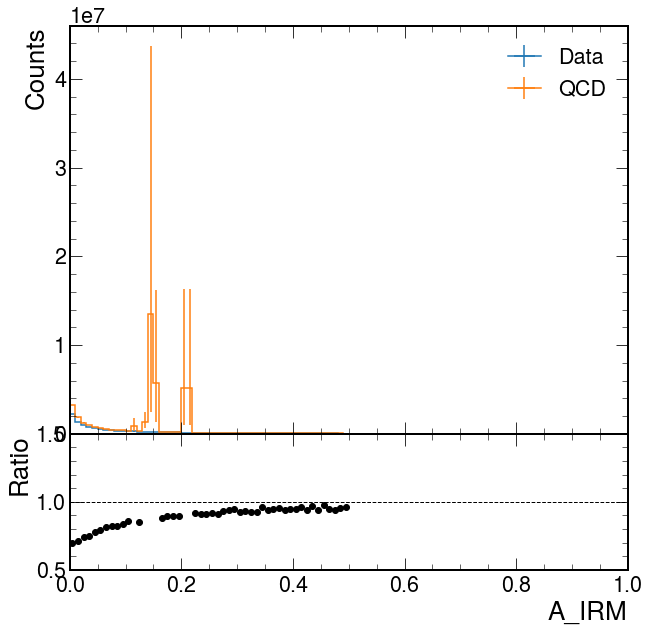

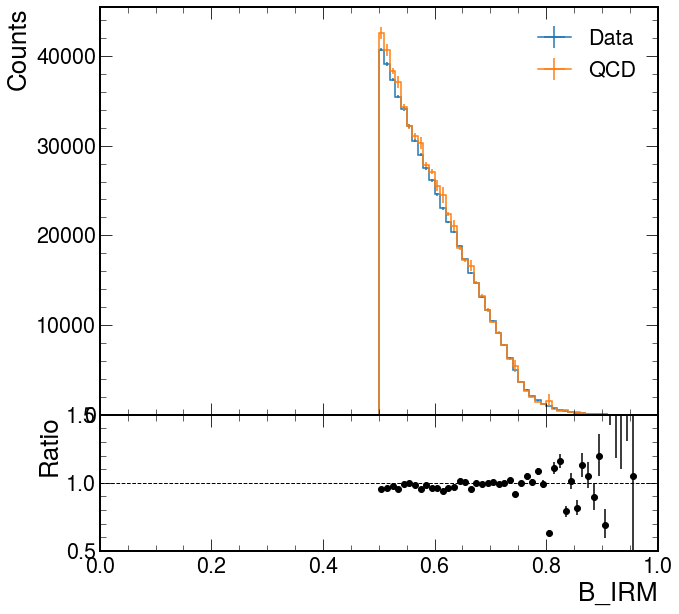

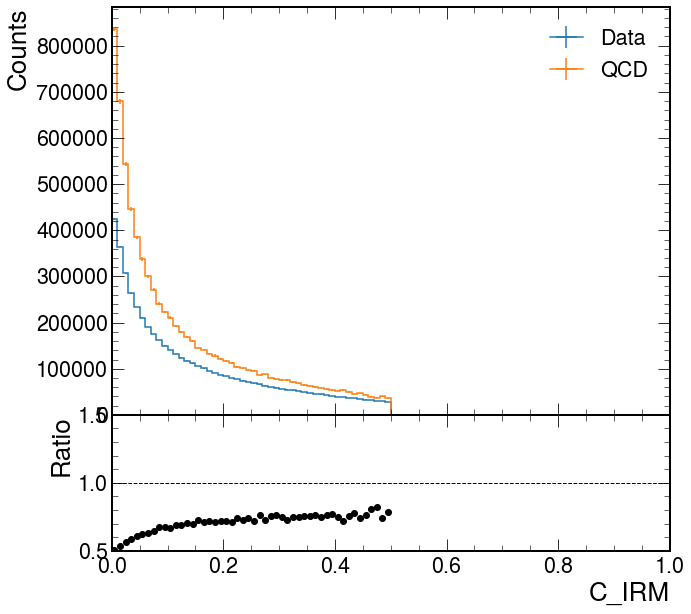

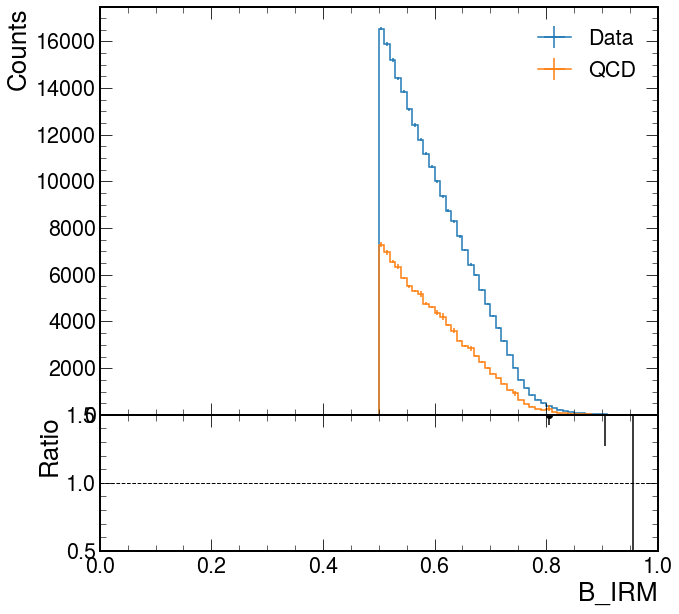

In [5]:
selection = 'IRM'
plot_labels = ['A','B','C','D_exp']
#plot_labels = ['A_ngood_fastjets']

for plot_label in plot_labels:
    
    plot_label += '_'+selection

    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label]
        
    _ = hdata.plot_ratio(hQCD_MC,
                     rp_num_label='Data',
                     rp_denom_label='QCD')
 
    #plt.xlim(0,100)
    plt.ylim(0.5,1.5)
    plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')
    plt.show()

## Ratio Plots: QCD D Region Closure
Make ratio plots to check ABCD closure in the D region.<br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>

In [ ]:
hQCD_MC_D_obs = plots['QCD_MC']['D_obs_IRM']
hQCD_MC_D_exp = plots['QCD_MC']['D_exp_IRM']

_ = hQCD_MC_D_obs.plot_ratio(hQCD_MC_D_exp,
                 rp_num_label='D observed',
                 rp_denom_label='D expected')

plt.xlabel("Sphericity")
plt.ylim(0.5,1.5)
plt.savefig(output_label + "_D_closure" + file_ext, bbox_inches='tight')
plt.show()

## Automatic Plotting
Make all plots in the pkl and save them automatically.<br>
For each 1D histogram in the pkl files, it prints a ratio plot for QCD vs. data, and plot with all samples plotted. 2D histograms are plotted separately by sample.

In [ ]:
plot_labels = [k for k in list(plots['QCD_MC'].keys())]
if not os.path.isdir(output_label+'allplots/'): os.system("mkdir " + str(output_label+'allplots/'))

for plot_label in plot_labels:
        
    print(plot_label, end=", ")
    
    # 2D plots
    if '2D' in plot_label:
        
        for sample in ['QCD_MC', 'data',
                   'SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']:

            if plots[sample][plot_label].sum().value == 0:
                print("Histogram empty for sample", sample, end=", ")
                continue

            hep.hist2dplot(plots[sample][plot_label], 
                       norm=matplotlib.colors.LogNorm(),
                       label=sample) 
            plt.savefig(output_label + 'allplots/' + plot_label+ "_"+sample+file_ext)
            plt.clf()
        
        
    # 1D variables
    elif '2D' not in plot_label:
        
        # ratio plot
        if "D_obs" not in plot_label:
            try:
                hQCD_MC = plots['QCD_MC'][plot_label]
                hdata = plots['data'][plot_label]
                _ = hdata.plot_ratio(hQCD_MC,
                                 rp_num_label='Data',
                                 rp_denom_label='QCD')
                plt.ylim(-1.0,1.0)
                plt.savefig(output_label + 'allplots/' + plot_label+ "_closure"+file_ext)
                plt.clf()
            except:
                print("One of the histograms is empty", end=", ")

        # plot everything
        for sample in ['QCD_MC', 'data',
                       'SUEP-m125-generic', 'SUEP-m400-generic', 'SUEP-m750-generic', 'SUEP-m1000-generic']:
            hep.histplot(plots[sample][plot_label], yerr=True, label=sample) 
        plt.legend()
        plt.yscale("log")
        plt.savefig(output_label + 'allplots/' + plot_label+ "_all"+file_ext)
        plt.clf()
    print()
print("All done")

## ABCD Independent Variables Check
1D slices of 2D plots, usually used to check the independence of the ABCD method's two variables on the QCD sample. This won't work if QCD has been binned by pt. <br>
N.B.: Imaginary numbers are used to access the bin value; using real numbers would access the bin number (see hist documentation for more info).<br>
Parameters:<br>
`plot_label`:_str_, which plot to analyze.<br>
`sample`: _str_, which sample to analyze.<br>
`slice_label`: _str_, variable being sliced, used in the plot legend.<br>
`slices`: _list of lists of floats_, bins of values to be sliced. e.g. for equal slices use np.linspace(start, end, number of bins), if not can specify as [[0,10],[20,40],[40,50],...].

In [ ]:
# parameters
plot_label = '2D_SUEP_spher_ntracks_IRM'
sample = 'QCD_MC'
slice_label = 'ntracks'            
#slices = [[0,15j],[15j,25j],[25j,35j],[35j,45j],[45j,200j]]
slices = [[0,40j],[40j,80j],[80j,120j],[120j,140j],[140j,160j],[160j,500j]]
#slices = [[0,0.2j],[0.2j,0.4j],[0.4j,0.6j],[0.6j,0.8j],[0.8j,1.0j]]
for i in range(len(slices)):
    val_lo = slices[i][0]
    val_up = slices[i][1]
    
    h = plots[sample][plot_label][0.25j:1.0j,val_lo:val_up:sum]
    #h = plots[sample][plot_label][val_lo:val_up:sum, 10j::8j]
            
    hep.histplot(h,
                 yerr=True, density=True, 
                 label=slice_label+" [{0},{1}]".format(val_lo.imag, val_up.imag))    

plt.legend()
plt.title(sample)
plt.xlim(0.0,1.0)
plt.yscale('log')
plt.ylabel("Normalized Events")
plt.xlabel("# Tracks")
plt.savefig(output_label + plot_label + "_1D_SLICES_" + file_ext,  bbox_inches='tight')

## Binned QCD Plots
Make plots with the QCD separated by bins. This won't work if QCD has been marged. <br>
Parameters:<br>
`selection`: _str_, which selection to use, e.g. 'ch', 'mult'.<br>
`plot_labels`: _list_, which plots you want to make.<br>
`identifier`: _str_, how to identify the QCD samples, e.g. QCD_HT or QCD_Pt.

In [ ]:
plot_labels = ['SUEP_ntracks_IRM']
identifier = 'QCD_Pt'

for plot_label in plot_labels:
    
    # get hists
    hlist, labels = [], []
    for key in plots.keys():
        if identifier in key:
            hlist.append(plots[key][plot_label])
            key = key.split('_Tune')[0]
            labels.append(key)
            
    # not sure why, but they NEED to be color coded appropriately
    vals = []
    for key in labels:
        if 'Pt' in identifier: keyslice = key.split(identifier+"_")[1]
        if 'HT' in identifier: keyslice = key.split(identifier)[1]
        keyslice = keyslice.split("to")[0]
        val = int(keyslice)
        vals.append(val)
    hlist_sorted, labels_sorted = [], []
    for arg in np.argsort(vals)[::-1]:
        hlist_sorted.append(hlist[arg])
        labels_sorted.append(labels[arg])
        
    cmap = plt.cm.rainbow(np.linspace(0, 1, len(labels_sorted)))
        
    hep.histplot(hlist_sorted, stack=True, label=labels_sorted, color=cmap)
    
plt.legend(fontsize=14, framealpha=1, facecolor='white', shadow=True, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.xlim(0.5,1.0)
plt.yscale("log")
plt.savefig(output_label + plot_label + file_ext, bbox_inches='tight')

## ABCD
Make the ABCD regions by hand from one of the 2D plots.<br>
Notation: `hist[v1:v2::sum]` sums along an axis from v1 to v2 (leave either blank to extend the summation bounds arbitrarily).

468849.8889974888
504816.30665672163


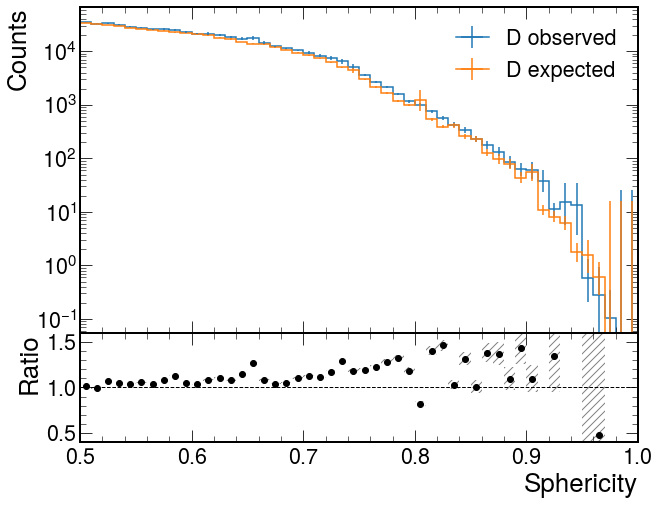

In [7]:
plot_label = '2D_SUEP_spher_ntracks_IRM'
abcd = plots['QCD_MC'][plot_label]
A = abcd[0.35j:0.5j,20j:100j:sum]
B = abcd[0.35j:0.5j,100j::sum]
C = abcd[0.5j:1.0j,20j:100j:sum]
D = abcd[0.5j:1.0j,100j::sum]
# A = abcd[0.25j:0.50j:sum,10j:100j:2j]
# B = abcd[0.25j:0.50j:sum,100j::2j]
# C = abcd[0.50j:1.0j:sum,10j:100j:2j]
# D = abcd[0.50j:1.0j:sum,100j::2j]
D_exp = C * B.sum().value / A.sum().value
print(D_exp.sum().value)
print(D.sum().value)
fig = plt.figure(figsize=(10, 8))
main, sub = D.plot_ratio(D_exp,
                rp_num_label='D observed',
                rp_denom_label='D expected',
                rp_uncert_draw_type="bar")
fig.axes[0].set_yscale("log")
fig.axes[0].set_xlim(0.5,1)
fig.axes[1].set_xlabel("Sphericity")
fig.axes[1].set_ylim(0.4,1.6)
plt.savefig(output_label+"ABCD_"+plot_label+file_ext)

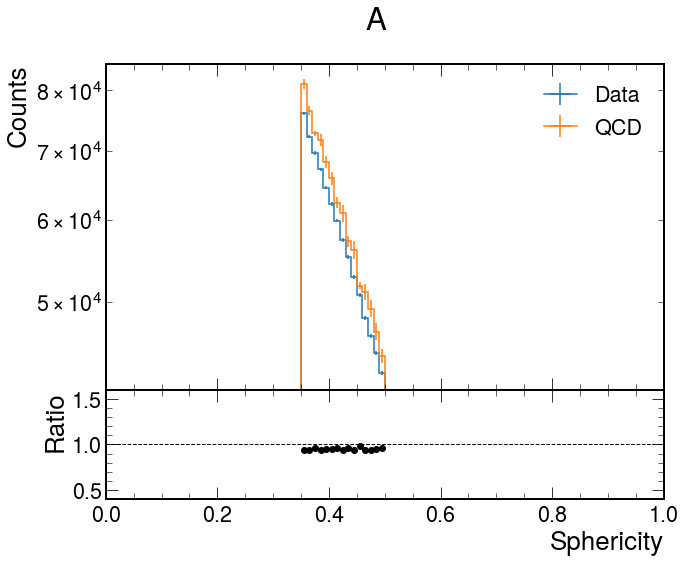

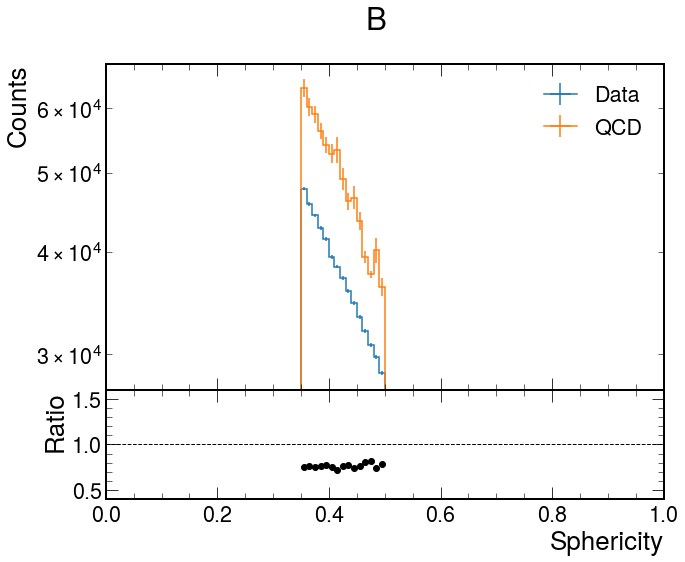

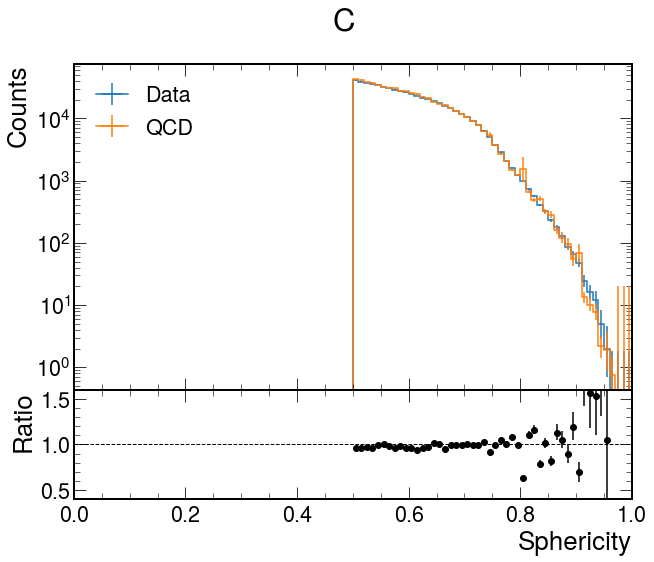

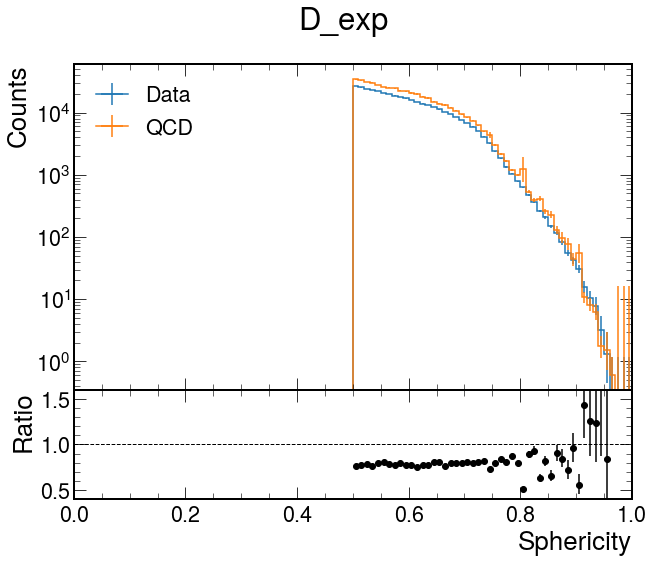

In [22]:
abcd = plots['QCD_MC'][plot_label]
A = abcd[0.35j:0.5j,20j:100j:sum]
B = abcd[0.35j:0.5j,100j::sum]
C = abcd[0.5j:1.0j,20j:100j:sum]
D = abcd[0.5j:1.0j,100j::sum]
D_exp = C * B.sum().value / A.sum().value

abcd_data = plots['data'][plot_label]
A_data = abcd_data[0.35j:0.5j,20j:100j:sum]
B_data = abcd_data[0.35j:0.5j,100j::sum]
C_data = abcd_data[0.5j:1.0j,20j:100j:sum]
D_exp_data = C_data * B_data.sum().value / A_data.sum().value


mc_hists, data_hists  = [A,B,C,D_exp], [A_data, B_data, C_data, D_exp_data]
labels = ['A','B','C','D_exp']
for h_MC, h_data, label in zip(mc_hists, data_hists, labels):
        
    fig = plt.figure(figsize=(10, 8))
    _ = h_data.plot_ratio(h_MC,
                     rp_num_label='Data',
                     rp_denom_label='QCD')
 
    fig.suptitle(label)
    fig.axes[0].set_yscale("log")
    fig.axes[0].set_xlim(0.0,1)
    fig.axes[1].set_xlabel("Sphericity")
    fig.axes[1].set_ylim(0.4,1.6)
    plt.savefig(output_label + plot_label + label + file_ext, bbox_inches='tight')
    plt.show()

## Calculate Yields
Integrate histograms to calculate yields.<br>
Parameters:<br>
`lumi`: _float_, scales MC data.<br>
`plot_label`: _str_, which plot you want to integrate.

In [ ]:
plot_label = 'PV_npvs_ch'
samples = ['SUEP-m125-generic', 'SUEP-m400-generic',
           'SUEP-m750-generic', 'SUEP-m1000-generic']

for sample in samples:
    h = plots[sample][plot_label]
    passing = h[0j:40j].sum().value
    total = h.sum().value
    print(sample, round(passing/total, 3))

## Table

Make comparison table by running next cells. The output is meant to be in Latex format.

In [ ]:
selection = 'ch'

for plot_label in ['A','B','C','D_exp']:
    
    plot_label+="_"+selection
    
    # QCD hist for ABCD region
    hdata = plots['data'][plot_label]
    hQCD_MC = plots['QCD_MC'][plot_label]
        
    # fill these up for the table
    stats['data'][plot_label]["value"] = hdata.sum().value
    stats['data'][plot_label]["err"] = hdata.sum().variance
    stats['QCD_MC'][plot_label]["value"] = hQCD_MC.sum().value
    stats['QCD_MC'][plot_label]["err"] = hQCD_MC.sum().variance

In [ ]:
table = []
for i in range(len(list(stats.keys()))):
    label = list(stats.keys())[i]
    line = []
    line.append(label)
    
    for r in ['A_'+selection,'B_'+selection,'C_'+selection,'D_exp_'+selection,'D_obs_'+selection]:
        if 'QCD_MC' in label:
            line.append("{:0.0f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.0f}".format(stats[label][r]['err']))
        else:
            line.append("{:0.2f} ".format(stats[label][r]['value']) + r'$\pm$' + " {:0.2f}".format(stats[label][r]['err']))
        
    if 'QCD_MC' in label:
        line.append(round((stats[label]['D_exp_'+selection]['value']-stats[label]['D_obs_'+selection]['value'])/stats[label]['D_exp_'+selection]['value'],2))
        line.append(0)
    else:
        line.append(0)
        line.append(stats[label]['D_obs_'+selection]['value']/math.sqrt(stats[label]['D_obs_'+selection]['value']+stats[label]['D_exp_'+selection]['value']+stats[label]['D_obs_'+selection]['err']+stats['QCD_MC']['D_exp_'+selection]['err']))
    table.append(line)                                                         

In [ ]:
t = tabulate(table,tablefmt ='latex',
               headers=['Process', 'A', 'B', 'C', 'D_{exp}', 'D_{obs}', 'D_{exp}-D_{obs}/D_{exp}', 'S/$\sqrt(S+B+\sigma_{S}+\sigma_{B}$)'])
with open('table.txt', 'w') as f:
    f.write(t)
t

In [ ]:
def convert2LatexString(s):
    r = r'(\^\{\})'; s = re.sub(r, "^", s)
    s = re.sub(r'\\([\$\_\{\}\^])', r'\1', s)
    s = re.sub(r'(\\textbackslash{})', r'\\', s)
    return s

t = convert2LatexString(t)
with open('table.txt', 'w') as f:
    f.write(t)
t